In [16]:
import numpy as np 
import pandas as pd

import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [150]:
train_info = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
test = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')

In [7]:
path_train = '../input/cassava-leaf-disease-classification/train_images/'

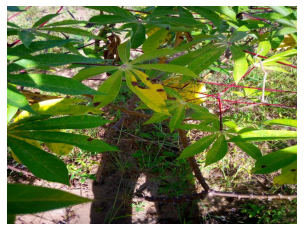

In [81]:
file_path = '../input/cassava-leaf-disease-classification/train_images/1000015157.jpg'
img = cv2.imread(file_path)
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

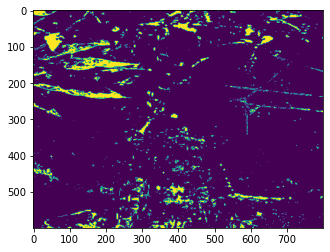

In [65]:
image = cv2.imread(file_path)
original = image.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower = np.array([56, 0, 28], dtype="uint8")
upper = np.array([219, 191, 205], dtype="uint8")
mask = cv2.inRange(image, lower, upper)

cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)

plt.imshow(mask)
#plt.imshow(original)

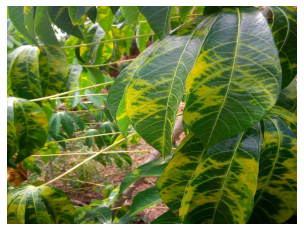

In [66]:
file_path = '../input/cassava-leaf-disease-classification/train_images/999474432.jpg'
img = cv2.imread(file_path)
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

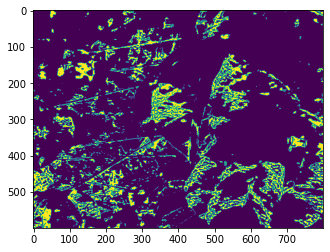

In [85]:
file_path = '../input/cassava-leaf-disease-classification/train_images/999474432.jpg'
img = cv2.imread(file_path)
image = cv2.imread(file_path)
original = image.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower = np.array([0, 150, 10], dtype="uint8")
upper = np.array([36, 251, 255], dtype="uint8")
mask = cv2.inRange(image, lower, upper)

cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)

plt.imshow(mask)
#plt.imshow(original)

In [147]:
def get_mask(file_name, color, type_image):
    file_path = f'../input/cassava-leaf-disease-classification/{type_image}/{file_name}'
    image = cv2.imread(file_path)
    original = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    if color == 'green':
        lower = np.array([36, 0, 0], dtype="uint8")
        upper = np.array([70, 255,255], dtype="uint8")
    if color == 'yellow':
        lower = np.array([0, 150, 10], dtype="uint8")
        upper = np.array([36, 251, 255], dtype="uint8")
    if color == 'violet':
        lower = np.array([56, 0, 28], dtype="uint8")
        upper = np.array([219, 191, 205], dtype="uint8")
    if color == 'orange':
        lower = np.array([18, 40, 90], dtype="uint8")
        upper = np.array([27, 255, 255], dtype="uint8")
    if color == 'brown':
        lower = np.array([30, 34, 45], dtype="uint8")
        upper = np.array([150, 172, 255], dtype="uint8")
    
    mask = cv2.inRange(image, lower, upper)

    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)

    return mask

In [149]:
def creat_shades_df(data, type_images):
    shades_df = pd.DataFrame(columns=['image_id', 'green', 'yellow', 'violet', 'orange', 'brown'])    

    for image_id in data['image_id'].values:
        green  = np.count_nonzero(get_mask(image_id, 'green' , type_images)==255)
        yellow = np.count_nonzero(get_mask(image_id, 'yellow', type_images)==255) / green
        violet = np.count_nonzero(get_mask(image_id, 'violet', type_images)==255) / green
        orange = np.count_nonzero(get_mask(image_id, 'orange', type_images)==255) / green
        brown  = np.count_nonzero(get_mask(image_id, 'brown' , type_images)==255) / green
        
        df1 = pd.DataFrame([[image_id, green, yellow, violet, orange, brown]], columns=['image_id', 'green', 'yellow', 'violet', 'orange', 'brown'])
        shades_df = pd.concat([shades_df, df1], axis=0)
    return shades_df

In [136]:
result_df = creat_shades_df(train_info, train_images)

In [138]:
#result_df.to_csv('train_shadows.csv', index=False)

In [139]:
data = result_df.merge(train_info, on='image_id')

In [152]:
result_test_df = creat_shades_df(test, 'test_images')

In [158]:
def model(train_data, test_data):
    X = train_data.drop(columns=['image_id', 'label']).values
    y = train_data['label'].values
    
    X_test = test_data.drop(columns=['image_id']).values
    
    cls = LogisticRegression(max_iter=1024)
    cls.fit(X, y)
    
    print('Making predictions')
    y_pred = cls.predict(X_test)
    
    test['label'] = y_pred
    
    print('Saving results')
    test.to_csv('submission.csv', index=False)
    
    print('Finished')